In [1]:
## import statements ##

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score

In [2]:
## data loading ##

## load data ##

data_rain = pd.read_csv('data_mrc/Rainfall_StungTreng.csv')
data_flow = pd.read_csv('data_mrc/Discharge_StungTreng.csv')

data_rain = data_rain.rename(columns={'Value': 'rainfall'})
data_flow = data_flow.rename(columns={'Value': 'flowrate'})

data_rain = data_rain[['Timestamp (UTC+07:00)', 'rainfall']]
data_flow = data_flow[['Timestamp (UTC+07:00)', 'flowrate']]

# merge data
df = pd.merge(data_rain, data_flow, on='Timestamp (UTC+07:00)', how='inner')
df['Timestamp (UTC+07:00)'] = pd.to_datetime(df['Timestamp (UTC+07:00)'], format='%Y-%m-%d %H:%M:%S')
df = df.rename(columns={'Timestamp (UTC+07:00)': 'date'})
df.set_index('date', inplace=True)

# Calculate the minimum flowrate over the past week / month (base flowrate)
df['min_flow_week'] = df['flowrate'].rolling(window=7, min_periods=1).min()
df['min_flow_month'] = df['flowrate'].rolling(window=30, min_periods=1).min()

# add lag rainfall features
df['rainfall_lag1'] = df['rainfall'].shift(1)
df['rainfall_lag2'] = df['rainfall'].shift(2)
df['rainfall_lag3'] = df['rainfall'].shift(3)
df['rainfall_lag5weeks'] = df['rainfall'].shift(35)
df['rainfall_week'] = df['rainfall'].rolling(window=7, min_periods=1).mean()
df['rainfall_total_week'] = df['rainfall'].rolling(window=7, min_periods=1).sum()

scaler_rain = StandardScaler()
df[['rainfall', 'rainfall_lag1','rainfall_lag2','rainfall_lag3', 'rainfall_week', 'rainfall_lag5weeks', 'rainfall_total_week']] = scaler_rain.fit_transform(df[['rainfall', 'rainfall_lag1','rainfall_lag2','rainfall_lag3', 'rainfall_week', 'rainfall_lag5weeks', 'rainfall_total_week']])
scaler_flow = StandardScaler()
df[['flowrate']] = scaler_flow.fit_transform(df[['flowrate']])
scaler_statflow = StandardScaler()
df[['min_flow_week','min_flow_month']] = scaler_statflow.fit_transform(df[['min_flow_week','min_flow_month']])

In [3]:
## encode datetime ##

# extract DateTime components
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['day_of_year'] = df.index.dayofyear
df['week_of_year'] = df.index.isocalendar().week.astype(int)

# encode cyclical features
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

In [4]:
df.describe()

,rainfall,flowrate,min_flow_week,min_flow_month,rainfall_lag1,rainfall_lag2,rainfall_lag3,rainfall_lag5weeks,rainfall_week,rainfall_total_week,year,month,day,day_of_week,day_of_year,week_of_year,day_of_week_sin,day_of_week_cos
count,4.693000e+03,4.693000e+03,4.693000e+03,4.693000e+03,4.692000e+03,4.691000e+03,4.690000e+03,4.658000e+03,4.693000e+03,4.693000e+03,4693.000000,4693.000000,4693.000000,4693.000000,4693.000000,4693.000000,4693.000000,4693.000000
mean,5.147763e-17,-9.992717e-17,9.689907e-17,-1.090115e-16,-5.451735e-17,-7.119060e-17,5.151056e-17,7.932207e-17,9.084288e-17,-8.478669e-17,2015.530151,6.604304,15.646708,3.004688,185.512465,26.871724,-0.002319,0.000127
std,1.000107e+00,1.000107e+00,1.000107e+00,1.000107e+00,1.000107e+00,1.000107e+00,1.000107e+00,1.000107e+00,1.000107e+00,1.000107e+00,4.122149,3.346634,8.812848,2.001699,102.276153,14.598409,0.707479,0.706882
min,-4.130685e-01,-1.006312e+00,-1.003426e+00,-9.790854e-01,-4.131200e-01,-4.131716e-01,-4.131653e-01,-4.148254e-01,-7.403805e-01,-7.402124e-01,2007.000000,1.000000,1.000000,0.000000,1.000000,1.000000,-0.974928,-0.900969
25%,-4.130685e-01,-7.344459e-01,-7.253982e-01,-6.652498e-01,-4.131200e-01,-4.131716e-01,-4.131653e-01,-4.148254e-01,-7.403805e-01,-7.402124e-01,2012.000000,4.000000,8.000000,1.000000,99.000000,14.000000,-0.781831,-0.900969
50%,-4.130685e-01,-5.080155e-01,-4.936505e-01,-4.632525e-01,-4.131200e-01,-4.131716e-01,-4.131653e-01,-4.148254e-01,-5.509488e-01,-5.507895e-01,2015.000000,7.000000,16.000000,3.000000,189.000000,27.000000,0.000000,-0.222521
75%,-1.103875e-01,5.516795e-01,4.977898e-01,4.047674e-01,-1.104658e-01,-1.105441e-01,-1.105691e-01,-1.130863e-01,5.339786e-01,5.340874e-01,2019.000000,9.000000,23.000000,5.000000,272.000000,39.000000,0.781831,0.623490
max,9.703202e+00,3.897269e+00,4.036488e+00,4.263678e+00,9.702257e+00,9.701311e+00,9.700271e+00,9.669965e+00,4.890909e+00,4.890815e+00,2024.000000,12.000000,31.000000,6.000000,366.000000,53.000000,0.974928,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4693 entries, 2007-03-07 00:00:00+00:00 to 2024-05-06 00:00:00+00:00
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rainfall             4693 non-null   float64
 1   flowrate             4693 non-null   float64
 2   min_flow_week        4693 non-null   float64
 3   min_flow_month       4693 non-null   float64
 4   rainfall_lag1        4692 non-null   float64
 5   rainfall_lag2        4691 non-null   float64
 6   rainfall_lag3        4690 non-null   float64
 7   rainfall_lag5weeks   4658 non-null   float64
 8   rainfall_week        4693 non-null   float64
 9   rainfall_total_week  4693 non-null   float64
 10  year                 4693 non-null   int64  
 11  month                4693 non-null   int64  
 12  day                  4693 non-null   int64  
 13  day_of_week          4693 non-null   int64  
 14  day_of_year          4693 non-null   int

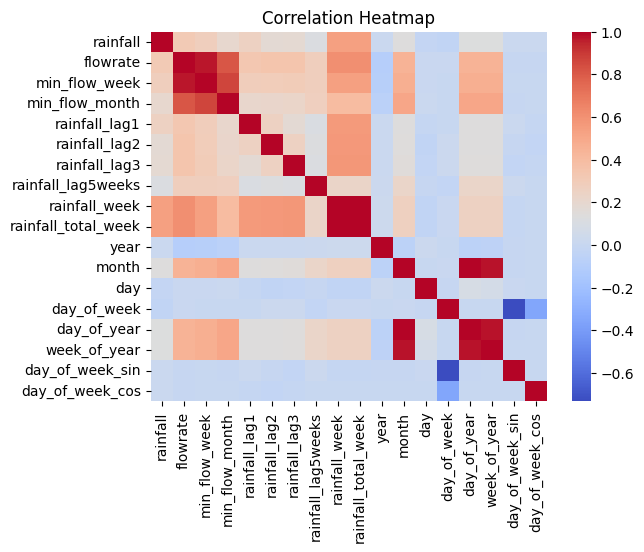

Index(['rainfall', 'flowrate', 'min_flow_week', 'min_flow_month',
       'rainfall_lag1', 'rainfall_lag2', 'rainfall_lag3', 'rainfall_lag5weeks',
       'rainfall_week', 'rainfall_total_week', 'year', 'month', 'day',
       'day_of_week', 'day_of_year', 'week_of_year', 'day_of_week_sin',
       'day_of_week_cos'],
      dtype='object')

In [6]:
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
df.columns

In [7]:
# drop non-needed columns
df = df.drop(columns=['year', 'day', 'day_of_week', 'day_of_year', 'day_of_week_sin', 'day_of_week_cos'])

# drop rows with missing values
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4658 entries, 2007-08-12 00:00:00+00:00 to 2024-05-06 00:00:00+00:00
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rainfall             4658 non-null   float64
 1   flowrate             4658 non-null   float64
 2   min_flow_week        4658 non-null   float64
 3   min_flow_month       4658 non-null   float64
 4   rainfall_lag1        4658 non-null   float64
 5   rainfall_lag2        4658 non-null   float64
 6   rainfall_lag3        4658 non-null   float64
 7   rainfall_lag5weeks   4658 non-null   float64
 8   rainfall_week        4658 non-null   float64
 9   rainfall_total_week  4658 non-null   float64
 10  month                4658 non-null   int64  
 11  week_of_year         4658 non-null   int32  
dtypes: float64(10), int32(1), int64(1)
memory usage: 454.9 KB


<Axes: >

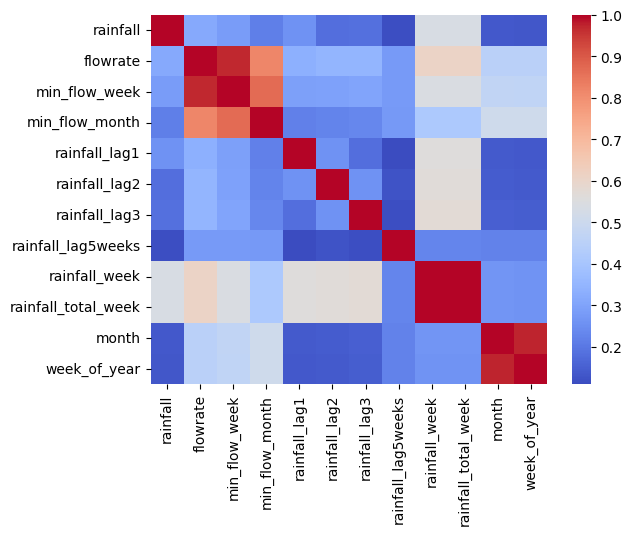

In [8]:
sns.heatmap(df.corr(), cmap='coolwarm')

## Set 1

In [9]:
## all data ##

X = df[['rainfall', 'week_of_year', 'rainfall_lag1', 'rainfall_lag2', 'rainfall_lag3', 'rainfall_total_week', 'rainfall_lag5weeks', 'min_flow_week', 'min_flow_month']]
y = df['flowrate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.sort_index()
y_train = y_train.sort_index()
X_test = X_test.sort_index()
y_test = y_test.sort_index()

dt_model = DecisionTreeRegressor()

# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mse = -cross_val_score(dt_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
cv_r2 = cross_val_score(dt_model, X_train, y_train, cv=kf, scoring='r2')
print("Decision Tree Model (all data included)")
print("Cross-Validated Mean Squared Error:", np.mean(cv_mse))
print("Cross-Validated R-squared:", np.mean(cv_r2))

# Train the model
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

dt_mse = mean_squared_error(y_test, dt_pred)
dt_r2 = r2_score(y_test, dt_pred)
print("Mean Squared Error:", dt_mse)
print("R-squared:", dt_r2)


# features importance
dt_feature_importances = dt_model.feature_importances_
dt_features = X.columns
importances_df = pd.DataFrame({'Feature': dt_features, 'Importance': dt_feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)
importances_df

Decision Tree Model (all data included)
Cross-Validated Mean Squared Error: 0.06680825793778757
Cross-Validated R-squared: 0.9295755224082622
Mean Squared Error: 0.0802338262316403
R-squared: 0.9243013602024813


,Feature,Importance
7,min_flow_week,0.952993
5,rainfall_total_week,0.013349
1,week_of_year,0.009440
8,min_flow_month,0.008121
4,rainfall_lag3,0.003655
3,rainfall_lag2,0.003588
2,rainfall_lag1,0.003261
6,rainfall_lag5weeks,0.002908
0,rainfall,0.002685


In [10]:
## hyperparameter tuning (all data) ##

param_grid = {
    'max_depth': [6, 7, 8, 9, 10, 11],
    'min_samples_split': [17, 18, 19, 20, 21],
    'min_samples_leaf': [2, 3, 4, 5, 6, 7],
    'max_features': ['sqrt', 'log2', 5, 6, 7, 8, 9]
}

# Create a Decision Tree Regressor
dt_opt = DecisionTreeRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=dt_opt, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best estimator
best_dt_regressor = grid_search.best_estimator_

# Make predictions
yopt_pred = best_dt_regressor.predict(X_test)

# Evaluate the model
mse_opt = mean_squared_error(y_test, yopt_pred)
r2_opt = r2_score(y_test, yopt_pred)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Mean Squared Error: {mse_opt}')
print(f'R-squared: {r2_opt}')

Best Parameters: {'max_depth': 7, 'max_features': 7, 'min_samples_leaf': 7, 'min_samples_split': 21}
Mean Squared Error: 0.0574882561281153
R-squared: 0.9457612456289219


## Set 2

In [11]:
## all rainfall lag & weekly baseline flowrate ##

X2 = df[['rainfall', 'week_of_year', 'rainfall_lag1', 'rainfall_lag2', 'rainfall_lag3', 'rainfall_lag5weeks', 'rainfall_total_week', 'min_flow_week']]
y2 = df['flowrate']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
X_train2 = X_train2.sort_index()
y_train2 = y_train2.sort_index()
X_test2 = X_test2.sort_index()
y_test2 = y_test2.sort_index()

dt_model2 = DecisionTreeRegressor()
dt_model2.fit(X_train2, y_train2)
dt_pred2 = dt_model2.predict(X_test2)

dt_mse2 = mean_squared_error(y_test2, dt_pred2)
dt_r2_2 = r2_score(y_test2, dt_pred2)

print("Decision Tree Model (Weekly Baseline Flowrate)")
print("Mean Squared Error:", dt_mse2)
print("R-squared:", dt_r2_2)

# features importance
dt_feature_importances2 = dt_model2.feature_importances_
dt_features2 = X2.columns
importances_df2 = pd.DataFrame({'Feature': dt_features2, 'Importance': dt_feature_importances2})
importances_df2 = importances_df2.sort_values(by='Importance', ascending=False)
importances_df2

Decision Tree Model (Weekly Baseline Flowrate)
Mean Squared Error: 0.08066027387004115
R-squared: 0.9238990173542341


,Feature,Importance
7,min_flow_week,0.956608
6,rainfall_total_week,0.013963
1,week_of_year,0.010326
3,rainfall_lag2,0.004595
2,rainfall_lag1,0.004532
4,rainfall_lag3,0.003906
5,rainfall_lag5weeks,0.003310
0,rainfall,0.002760


In [12]:
## hyperparameter tuning (all rainfall lag & weekly baseline flowrate) ##

param_grid = {
    'max_depth': [6, 7, 8, 9, 10, 11],
    'min_samples_split': [17, 18, 19, 20, 21],
    'min_samples_leaf': [2, 3, 4, 5, 6, 7],
    'max_features': ['sqrt', 'log2', 5, 6, 7, 8, 9]
}

# Create a Decision Tree Regressor
dt_opt2 = DecisionTreeRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=dt_opt2, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search.fit(X_train2, y_train2)

# Get the best estimator
best_dt_regressor = grid_search.best_estimator_

# Make predictions
yopt_pred2 = best_dt_regressor.predict(X_test2)

# Evaluate the model
mse_opt2 = mean_squared_error(y_test2, yopt_pred2)
r2_opt2 = r2_score(y_test2, yopt_pred2)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Mean Squared Error: {mse_opt2}')
print(f'R-squared: {r2_opt2}')

Best Parameters: {'max_depth': 6, 'max_features': 6, 'min_samples_leaf': 5, 'min_samples_split': 19}
Mean Squared Error: 0.05482128770176274
R-squared: 0.9482774646819054


## Set 3

In [13]:
## all rainfall lag & monthly baseline flowrate ##

X3 = df[['rainfall', 'week_of_year', 'rainfall_lag1', 'rainfall_lag2', 'rainfall_lag3', 'rainfall_lag5weeks', 'rainfall_total_week', 'min_flow_month']]
y3 = df['flowrate']

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)
X_train3 = X_train3.sort_index()
y_train3 = y_train3.sort_index()
X_test3 = X_test3.sort_index()
y_test3 = y_test3.sort_index()

dt_model3 = DecisionTreeRegressor()
dt_model3.fit(X_train3, y_train3)
dt_pred3 = dt_model3.predict(X_test3)

dt_mse3 = mean_squared_error(y_test3, dt_pred3)
dt_r2_3 = r2_score(y_test3, dt_pred3)

print("Decision Tree Model (Monthly Baseline Flowrate)")
print("Mean Squared Error:", dt_mse3)
print("R-squared:", dt_r2_3)

# features importance
dt_feature_importances3 = dt_model3.feature_importances_
dt_features3 = X3.columns
importances_df3 = pd.DataFrame({'Feature': dt_features3, 'Importance': dt_feature_importances3})
importances_df3 = importances_df3.sort_values(by='Importance', ascending=False)
importances_df3

Decision Tree Model (Monthly Baseline Flowrate)
Mean Squared Error: 0.11712331347462629
R-squared: 0.8894970371597304


,Feature,Importance
7,min_flow_month,0.682999
1,week_of_year,0.240588
6,rainfall_total_week,0.040098
3,rainfall_lag2,0.010531
4,rainfall_lag3,0.008128
5,rainfall_lag5weeks,0.007592
0,rainfall,0.006118
2,rainfall_lag1,0.003945


In [14]:
## hyperparameter tuning (all rainfall lag & monthly baseline flowrate) ##

param_grid = {
    'max_depth': [4, 5, 6, 7, 8, 9],
    'min_samples_split': [18, 19, 20, 21, 22, 23],
    'min_samples_leaf': [2, 3, 4, 5, 6, 7],
    'max_features': ['sqrt', 'log2', 5, 6, 7, 8, 9]
}

dt_opt3 = DecisionTreeRegressor()
grid_search = GridSearchCV(estimator=dt_opt3, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train3, y_train3)
best_dt_regressor = grid_search.best_estimator_
yopt_pred3 = best_dt_regressor.predict(X_test3)

# Evaluate the model
mse_opt3 = mean_squared_error(y_test3, yopt_pred3)
r2_opt3 = r2_score(y_test3, yopt_pred3)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Mean Squared Error: {mse_opt3}')
print(f'R-squared: {r2_opt3}')

Best Parameters: {'max_depth': 6, 'max_features': 7, 'min_samples_leaf': 4, 'min_samples_split': 19}
Mean Squared Error: 0.1411756844333288
R-squared: 0.8668042172981604


## Set 4

In [15]:
## week rainfall mean & weekly baseline flowrate ##

X4 = df[['rainfall_week', 'week_of_year', 'rainfall', 'min_flow_week']]
y4 = df['flowrate']

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.2, random_state=42)
X_train4 = X_train4.sort_index()
y_train4 = y_train4.sort_index()
X_test4 = X_test4.sort_index()
y_test4 = y_test4.sort_index()

dt_model4 = DecisionTreeRegressor()

# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mse4 = -cross_val_score(dt_model4, X_train4, y_train4, cv=kf, scoring='neg_mean_squared_error')
cv_r24 = cross_val_score(dt_model4, X_train4, y_train4, cv=kf, scoring='r2')

print("Decision Tree Model (Weekly Baseline & Weekly Mean Rainfall)")
print("Cross-Validated Mean Squared Error:", np.mean(cv_mse4))
print("Cross-Validated R-squared:", np.mean(cv_r24))

dt_model4.fit(X_train4, y_train4)
dt_pred4 = dt_model4.predict(X_test4)

dt_mse4 = mean_squared_error(y_test4, dt_pred4)
dt_r2_4 = r2_score(y_test4, dt_pred4)

print("Mean Squared Error:", dt_mse4)
print("R-squared:", dt_r2_4)

# features importance
dt_feature_importances4 = dt_model4.feature_importances_
dt_features4 = X4.columns
importances_df4 = pd.DataFrame({'Feature': dt_features4, 'Importance': dt_feature_importances4})
importances_df4 = importances_df4.sort_values(by='Importance', ascending=False)
importances_df4

Decision Tree Model (Weekly Baseline & Weekly Mean Rainfall)
Cross-Validated Mean Squared Error: 0.06050195039243913
Cross-Validated R-squared: 0.936715536545089
Mean Squared Error: 0.060577660323072935
R-squared: 0.9428464688280767


,Feature,Importance
3,min_flow_week,0.960198
0,rainfall_week,0.019111
1,week_of_year,0.014383
2,rainfall,0.006308


In [16]:
dt_model4.get_depth()

25

In [17]:
## hyperparameter tuning (week rainfall mean & weekly baseline flowrate) ##

param_grid = {
    'max_depth': [4, 5, 6, 7, 8, 9],
    'min_samples_split': [15, 16, 17, 18, 19, 20],
    'min_samples_leaf': [3, 4, 5, 6, 7, 8],
    'max_features': ['sqrt', 'log2', 5, 6, 7, 8, 9]
}

dt_opt4 = DecisionTreeRegressor()
grid_search = GridSearchCV(estimator=dt_opt4, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train4, y_train4)
best_dt_regressor = grid_search.best_estimator_
yopt_pred4 = best_dt_regressor.predict(X_test4)

# Evaluate the model
mse_opt4 = mean_squared_error(y_test4, yopt_pred4)
r2_opt4 = r2_score(y_test4, yopt_pred4)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Mean Squared Error: {mse_opt4}')
print(f'R-squared: {r2_opt4}')

Best Parameters: {'max_depth': 6, 'max_features': 5, 'min_samples_leaf': 8, 'min_samples_split': 15}
Mean Squared Error: 0.050620847629484295
R-squared: 0.9522404764807504


## Set 5

In [18]:
## total weekly rainfall & monthly baseline flowrate ##
X5 = df[['rainfall', 'week_of_year', 'rainfall_total_week', 'min_flow_month']]
y5 = df['flowrate']

X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.2, random_state=42)
X_train5 = X_train5.sort_index()
y_train5 = y_train5.sort_index()
X_test5 = X_test5.sort_index()
y_test5 = y_test5.sort_index()

dt_model5 = DecisionTreeRegressor()
dt_model5.fit(X_train5, y_train5)
dt_pred5 = dt_model5.predict(X_test5)

dt_mse5 = mean_squared_error(y_test5, dt_pred5)
dt_r2_5 = r2_score(y_test5, dt_pred5)

print("Decision Tree Model (Monthly Baseline & Weekly Mean Rainfall)")
print("Mean Squared Error:", dt_mse5)
print("R-squared:", dt_r2_5)

# features importance
dt_feature_importances5 = dt_model5.feature_importances_
dt_features5 = X5.columns
importances_df5 = pd.DataFrame({'Feature': dt_features5, 'Importance': dt_feature_importances5})
importances_df5 = importances_df5.sort_values(by='Importance', ascending=False)
importances_df5

Decision Tree Model (Monthly Baseline & Weekly Mean Rainfall)
Mean Squared Error: 0.11524245669443196
R-squared: 0.8912715792276057


,Feature,Importance
3,min_flow_month,0.691029
1,week_of_year,0.248195
2,rainfall_total_week,0.050641
0,rainfall,0.010135


In [19]:
## hyperparameter tuning (week rainfall mean & weekly baseline flowrate) ##

param_grid = {
    'max_depth': [7, 8, 9, 10, 11, 12, 13, 15],
    'min_samples_split': [17, 18, 19, 20, 21, 22, 23, 24],
    'min_samples_leaf': [7, 8, 9, 10, 11, 12, 13, 14, 15],
    'max_features': ['sqrt', 'log2', 4, 5, 6, 7, 8]
}

dt_opt5= DecisionTreeRegressor()
grid_search = GridSearchCV(estimator=dt_opt5, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train5, y_train5)
best_dt_regressor = grid_search.best_estimator_
yopt_pred5 = best_dt_regressor.predict(X_test5)

# Evaluate the model
mse_opt5 = mean_squared_error(y_test5, yopt_pred5)
r2_opt5 = r2_score(y_test5, yopt_pred5)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Mean Squared Error: {mse_opt5}')
print(f'R-squared: {r2_opt5}')

Best Parameters: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 22}
Mean Squared Error: 0.137440558894658
R-squared: 0.8703282162899828


## Set 6

In [20]:
## all data no baseline ##

X6 = df[['rainfall', 'week_of_year', 'rainfall_lag1', 'rainfall_lag2', 'rainfall_lag3', 'rainfall_total_week', 'rainfall_lag5weeks']]
y6 = df['flowrate']

X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, y6, test_size=0.2, random_state=42)
X_train6 = X_train6.sort_index()
y_train6 = y_train6.sort_index()
X_test6 = X_test6.sort_index()
y_test6 = y_test6.sort_index()

dt_model6 = DecisionTreeRegressor()

# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mse6 = -cross_val_score(dt_model6, X_train6, y_train6, cv=kf, scoring='neg_mean_squared_error')
cv_r26 = cross_val_score(dt_model6, X_train6, y_train6, cv=kf, scoring='r2')
print("Decision Tree Model (all data no baseline)")
print("Cross-Validated Mean Squared Error:", np.mean(cv_mse6))
print("Cross-Validated R-squared:", np.mean(cv_r26))

# Train the model
dt_model6.fit(X_train6, y_train6)
dt_pred6 = dt_model6.predict(X_test6)

dt_mse6 = mean_squared_error(y_test6, dt_pred6)
dt_r26 = r2_score(y_test6, dt_pred6)
print("Mean Squared Error:", dt_mse6)
print("R-squared:", dt_r26)


# features importance
dt_feature_importances6 = dt_model6.feature_importances_
dt_features6 = X6.columns
importances_df6 = pd.DataFrame({'Feature': dt_features6, 'Importance': dt_feature_importances6})
importances_df6 = importances_df6.sort_values(by='Importance', ascending=False)
importances_df6

Decision Tree Model (all data no baseline)
Cross-Validated Mean Squared Error: 0.3780937127923162
Cross-Validated R-squared: 0.6252998324880222
Mean Squared Error: 0.3591122136817383
R-squared: 0.6611864672650586


,Feature,Importance
1,week_of_year,0.784410
5,rainfall_total_week,0.086330
3,rainfall_lag2,0.034606
6,rainfall_lag5weeks,0.026882
4,rainfall_lag3,0.025716
2,rainfall_lag1,0.023562
0,rainfall,0.018494


In [21]:
## hyperparameter tuning (All data, no baseline)) ##

param_grid = {
    'max_depth': [7, 8, 9, 10, 11, 12],
    'min_samples_split': [22, 23, 24, 25, 26, 27, 28],
    'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9],
    'max_features': ['sqrt', 'log2', 4, 5, 6, 7]
}

dt_opt6= DecisionTreeRegressor()
grid_search = GridSearchCV(estimator=dt_opt6, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train6, y_train6)
best_dt_regressor = grid_search.best_estimator_
yopt_pred6 = best_dt_regressor.predict(X_test6)

# Evaluate the model
mse_opt6 = mean_squared_error(y_test6, yopt_pred6)
r2_opt6 = r2_score(y_test6, yopt_pred6)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Mean Squared Error: {mse_opt6}')
print(f'R-squared: {r2_opt6}')

Best Parameters: {'max_depth': 7, 'max_features': 5, 'min_samples_leaf': 9, 'min_samples_split': 24}
Mean Squared Error: 0.2501972819102154
R-squared: 0.7639450240480894


## Set 7

In [22]:
## Weekly Baseline, Rainfall & 5 weeks rainfall lag ##

X7 = df[['rainfall', 'week_of_year', 'rainfall_lag5weeks', 'rainfall_total_week', 'min_flow_week']]
y7 = df['flowrate']

X_train7, X_test7, y_train7, y_test7 = train_test_split(X7, y7, test_size=0.2, random_state=42)

dt_model_day = DecisionTreeRegressor()

# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mse_day = -cross_val_score(dt_model_day, X_train7, y_train7, cv=kf, scoring='neg_mean_squared_error')
cv_r2_day = cross_val_score(dt_model_day, X_train7, y_train7, cv=kf, scoring='r2')

print("Decision Tree Model (all data, day of year)")
print("Cross-Validated Mean Squared Error:", np.mean(cv_mse_day))
print("Cross-Validated R-squared:", np.mean(cv_r2_day))

dt_model_day.fit(X_train7, y_train7)
dt_pred_day = dt_model_day.predict(X_test7)
dt_day_mse = mean_squared_error(y_test7, dt_pred_day)
dt_day_r2 = r2_score(y_test7, dt_pred_day)

print("Mean Squared Error:", dt_day_mse)
print("R-squared:", dt_day_r2)

# features importance
dt_day_feature_importances = dt_model_day.feature_importances_
dt_day_features = X7.columns
importances_df_day = pd.DataFrame({'Feature': dt_day_features, 'Importance': dt_day_feature_importances})
importances_df_day = importances_df_day.sort_values(by='Importance', ascending=False)
importances_df_day

Decision Tree Model (all data, day of year)
Cross-Validated Mean Squared Error: 0.06269009613703462
Cross-Validated R-squared: 0.9338923317428195
Mean Squared Error: 0.0770484769421703
R-squared: 0.9273066588379562


,Feature,Importance
4,min_flow_week,0.959897
3,rainfall_total_week,0.018284
1,week_of_year,0.012082
0,rainfall,0.004906
2,rainfall_lag5weeks,0.004831


In [23]:
## hyperparameter tuning (Weekly Baseline, Rainfall & 5 weeks rainfall lag) ##

param_grid = {
    'max_depth': [12, 13, 15, 16, 17, 18, 19],
    'min_samples_split': [17, 18, 19, 20, 21, 22, 23, 24, 25],
    'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9],
    'max_features': ['sqrt', 'log2', 2, 3, 4, 5, 6, 7, 8]
}

dt_opt7= DecisionTreeRegressor()
grid_search = GridSearchCV(estimator=dt_opt7, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train7, y_train7)
best_dt_regressor = grid_search.best_estimator_
yopt_pred7 = best_dt_regressor.predict(X_test7)

# Evaluate the model
mse_opt7 = mean_squared_error(y_test7, yopt_pred7)
r2_opt7 = r2_score(y_test7, yopt_pred7)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Mean Squared Error: {mse_opt7}')
print(f'R-squared: {r2_opt7}')

Best Parameters: {'max_depth': 13, 'max_features': 4, 'min_samples_leaf': 4, 'min_samples_split': 21}
Mean Squared Error: 0.05117389272825115
R-squared: 0.951718692045312


## Random forest

In [24]:
## random forest model ##

X_rf = df[['rainfall', 'week_of_year', 'rainfall_lag1', 'rainfall_lag2', 'rainfall_lag3', 'rainfall_lag5weeks', 'rainfall_total_week', 'min_flow_week', 'min_flow_month']]
y_rf = df['flowrate']

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)
X_train_rf = X_train_rf.sort_index()
y_train_rf = y_train_rf.sort_index()
X_test_rf = X_test_rf.sort_index()
y_test_rf = y_test_rf.sort_index()

rf_model = RandomForestRegressor()

# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mse_rf = -cross_val_score(rf_model, X_train_rf, y_train_rf, cv=kf, scoring='neg_mean_squared_error')
cv_r2_rf = cross_val_score(rf_model, X_train_rf, y_train_rf, cv=kf, scoring='r2')

print("Random Forest Model (all data included)")
print("Cross-Validated Mean Squared Error:", np.mean(cv_mse_rf))
print("Cross-Validated R-squared:", np.mean(cv_r2_rf))

rf_model.fit(X_train_rf, y_train_rf)
rf_pred = rf_model.predict(X_test_rf)

rf_mse = mean_squared_error(y_test_rf, rf_pred)
rf_r2 = r2_score(y_test_rf, rf_pred)

print("Mean Squared Error:", rf_mse)
print("R-squared:", rf_r2)

# features importance
rf_feature_importances = rf_model.feature_importances_
rf_features = X_rf.columns
importances_rf = pd.DataFrame({'Feature': rf_features, 'Importance': rf_feature_importances})
importances_rf = importances_rf.sort_values(by='Importance', ascending=False)
importances_rf

# Reverse scaling (if applicable)
if 'scaler_flow' in globals():
    y_test_rf = scaler_flow.inverse_transform(y_test_rf.values.reshape(-1, 1))
    rf_pred = scaler_flow.inverse_transform(rf_pred.reshape(-1, 1))
importances_rf

Random Forest Model (all data included)
Cross-Validated Mean Squared Error: 0.035221693246272695
Cross-Validated R-squared: 0.9638581273957444
Mean Squared Error: 0.03638871239876126
R-squared: 0.9656681456943523


,Feature,Importance
7,min_flow_week,0.951228
6,rainfall_total_week,0.012265
8,min_flow_month,0.007617
1,week_of_year,0.007370
3,rainfall_lag2,0.005497
4,rainfall_lag3,0.005087
2,rainfall_lag1,0.004175
0,rainfall,0.003552
5,rainfall_lag5weeks,0.003209


In [25]:
## random forest model (Weekly Baseline, Rainfall & 5 weeks rainfall lag) ##

X_rf2 = df[['rainfall', 'week_of_year', 'rainfall_lag5weeks', 'rainfall_total_week', 'min_flow_week']]
y_rf2 = df['flowrate']

X_train_rf2, X_test_rf2, y_train_rf2, y_test_rf2 = train_test_split(X_rf2, y_rf2, test_size=0.2, random_state=42)
X_train_rf2 = X_train_rf2.sort_index()
y_train_rf2 = y_train_rf2.sort_index()
X_test_rf2 = X_test_rf2.sort_index()
y_test_rf2 = y_test_rf2.sort_index()

rf_model2 = RandomForestRegressor()

# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mse_rf2 = -cross_val_score(rf_model2, X_train_rf2, y_train_rf2, cv=kf, scoring='neg_mean_squared_error')
cv_r2_rf2 = cross_val_score(rf_model2, X_train_rf2, y_train_rf2, cv=kf, scoring='r2')

print("Random Forest Model (Weekly Baseline, Rainfall & 5 weeks rainfall lag)")
print("Cross-Validated Mean Squared Error:", np.mean(cv_mse_rf2))
print("Cross-Validated R-squared:", np.mean(cv_r2_rf2))

rf_model2.fit(X_train_rf2, y_train_rf2)
rf_pred2 = rf_model2.predict(X_test_rf2)

rf_mse2 = mean_squared_error(y_test_rf2, rf_pred2)
rf_r22 = r2_score(y_test_rf2, rf_pred2)

print("Mean Squared Error:", rf_mse2)
print("R-squared:", rf_r22)

# features importance
rf_feature_importances2 = rf_model2.feature_importances_
rf_features2 = X_rf2.columns
importances_rf2 = pd.DataFrame({'Feature': rf_features2, 'Importance': rf_feature_importances2})
importances_rf2 = importances_rf2.sort_values(by='Importance', ascending=False)

# Reverse scaling (if applicable)
if 'scaler_flow' in globals():
    y_test_rf2 = scaler_flow.inverse_transform(y_test_rf2.values.reshape(-1, 1))
    rf_pred2 = scaler_flow.inverse_transform(rf_pred2.reshape(-1, 1))
    
importances_rf2


Random Forest Model (Weekly Baseline, Rainfall & 5 weeks rainfall lag)
Cross-Validated Mean Squared Error: 0.03562357859344567
Cross-Validated R-squared: 0.9636993889327327
Mean Squared Error: 0.03835990189500664
R-squared: 0.9638083769327562


,Feature,Importance
4,min_flow_week,0.956943
3,rainfall_total_week,0.019390
1,week_of_year,0.011473
0,rainfall,0.006438
2,rainfall_lag5weeks,0.005755


## XGBoost

In [26]:
## XGBoost ##
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective='reg:squarederror' , random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

print("XGBoost Model (all data included)")
print("Mean Squared Error:", xgb_mse)
print("R-squared:", xgb_r2)

# features importance
xgb_feature_importances = xgb_model.feature_importances_
xgb_features = X.columns
importances_xgb_df = pd.DataFrame({'Feature': xgb_features, 'Importance': xgb_feature_importances})
importances_xgb_df = importances_xgb_df.sort_values(by='Importance', ascending=False)
importances_xgb_df

XGBoost Model (all data included)
Mean Squared Error: 0.04125243647105322
R-squared: 0.9610793417706806


,Feature,Importance
7,min_flow_week,0.940094
5,rainfall_total_week,0.012732
8,min_flow_month,0.010970
1,week_of_year,0.009694
3,rainfall_lag2,0.006819
4,rainfall_lag3,0.006556
6,rainfall_lag5weeks,0.005158
2,rainfall_lag1,0.004665
0,rainfall,0.003311


In [27]:
## XGBoost (Weekly Baseline, Rainfall & 5 weeks rainfall lag) ##
import xgboost as xgb

xgb_model2 = xgb.XGBRegressor(objective='reg:squarederror' , random_state=42)
xgb_model2.fit(X_train7, y_train7)
xgb_pred2 = xgb_model2.predict(X_test7)

xgb_mse2 = mean_squared_error(y_test7, xgb_pred2)
xgb_r22 = r2_score(y_test7, xgb_pred2)

print("XGBoost Model (Weekly Baseline, Rainfall & 5 weeks rainfall lag)")
print("Mean Squared Error:", xgb_mse2)
print("R-squared:", xgb_r22)

# features importance
xgb_feature_importances2 = xgb_model2.feature_importances_
xgb_features2 = X7.columns
importances_xgb_df2 = pd.DataFrame({'Feature': xgb_features2, 'Importance': xgb_feature_importances2})
importances_xgb_df2 = importances_xgb_df2.sort_values(by='Importance', ascending=False)
importances_xgb_df2

XGBoost Model (Weekly Baseline, Rainfall & 5 weeks rainfall lag)
Mean Squared Error: 0.040909251189780824
R-squared: 0.9614031286347875


,Feature,Importance
4,min_flow_week,0.954957
3,rainfall_total_week,0.017533
1,week_of_year,0.013458
2,rainfall_lag5weeks,0.007212
0,rainfall,0.006840


## Results

In [28]:
## dataframe to store results ##
results = pd.DataFrame(columns=['Decision Tree Model', 'Mean Squared Error', 'R-squared'])
results.loc[0] = ['All Data', dt_mse, dt_r2]
results.loc[1] = ['Weekly Baseline', dt_mse2, dt_r2_2]
results.loc[2] = ['Monthly Baseline', dt_mse3, dt_r2_3]
results.loc[3] = ['Weekly Baseline & Total Weekly Rain', dt_mse4, dt_r2_4]
results.loc[4] = ['Monthly Baseline & Total Weekly Rain', dt_mse5, dt_r2_5]
results.loc[5] = ['RF (all data)', rf_mse, rf_r2]
results.loc[6] = ['XGBoost (all data)', xgb_mse, xgb_r2]
results.loc[7] = ['Optimized (all data)', mse_opt, r2_opt]
results.loc[8] = ['Optimized (Weekly Baseline)', mse_opt2, r2_opt2]
results.loc[9] = ['Optimized (Monthly Baseline)', mse_opt3, r2_opt3]
results.loc[10] = ['Optimized (Weekly Baseline & Total Weekly Rain)', mse_opt4, r2_opt4]
results.loc[11] = ['Optimized (Monthly Baseline & Total Weekly Rain)', mse_opt5, r2_opt5]
results.loc[12] = ['Weekly Baseline, Rainfall & 5 weeks rainfall lag', dt_day_mse, dt_day_r2]
results.loc[13] = ['XGBoost (Weekly Baseline, Rainfall & 5 weeks rainfall lag)', xgb_mse2, xgb_r22]
results.loc[14] = ['Optimized (Weekly Baseline, Rainfall & 5 weeks rainfall lag)', mse_opt7, r2_opt7]
results.loc[15] = ['RF (Weekly Baseline, Rainfall & 5 weeks rainfall lag)', rf_mse2, rf_r22]
results.loc[16] = ['All data, No baseline flowrate', dt_mse6, dt_r26]
results.loc[17] = ['Optimized (All data, No baseline flowrate)', mse_opt6, r2_opt6]
results = results.sort_values(by='Mean Squared Error')
results

,Decision Tree Model,Mean Squared Error,R-squared
5,RF (all data),0.036389,0.965668
15,"RF (Weekly Baseline, Rainfall & 5 weeks rainfa...",0.038360,0.963808
13,"XGBoost (Weekly Baseline, Rainfall & 5 weeks r...",0.040909,0.961403
6,XGBoost (all data),0.041252,0.961079
10,Optimized (Weekly Baseline & Total Weekly Rain),0.050621,0.952240
14,"Optimized (Weekly Baseline, Rainfall & 5 weeks...",0.051174,0.951719
8,Optimized (Weekly Baseline),0.054821,0.948277
7,Optimized (all data),0.057488,0.945761
3,Weekly Baseline & Total Weekly Rain,0.060578,0.942846
12,"Weekly Baseline, Rainfall & 5 weeks rainfall lag",0.077048,0.927307


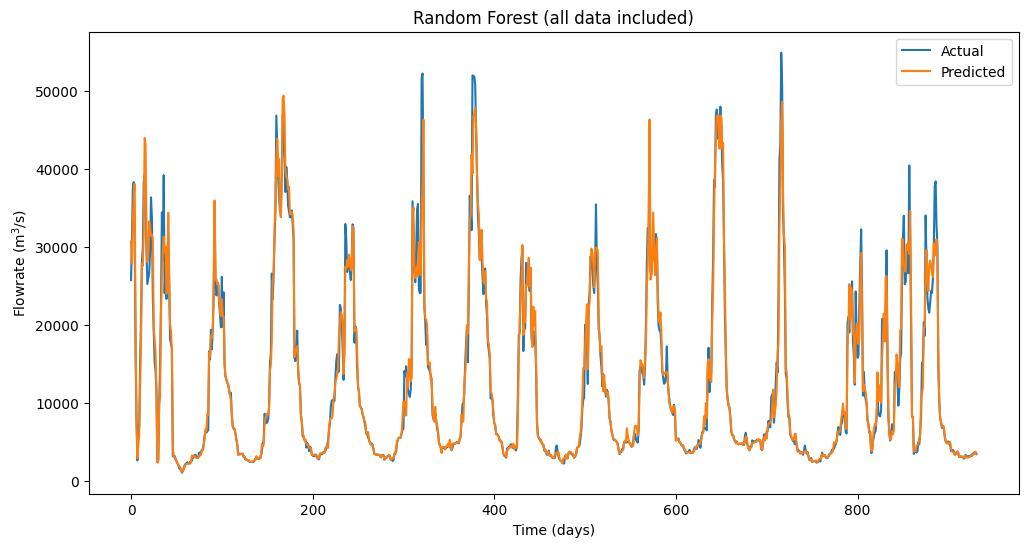

In [29]:
## Plot the best model ##
plt.figure(figsize=(12, 6))
plt.plot(y_test_rf, label='Actual')
plt.plot(rf_pred, label='Predicted')
plt.title('Random Forest (all data included)')
plt.xlabel('Time (days)')
plt.ylabel('Flowrate (m$^3$/s)')
plt.legend()
plt.show()